In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np

# Load your dataset
# Replace 'file_path' with the path to your extended dataset file
data = pd.read_csv('RomanicBanglaSentiment.csv')

# Split data into features (X) and labels (y)
X = data['text']
y = data['sentiment']

# Encode labels into numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create a Hugging Face Dataset
data_hf = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data_hf = data_hf.train_test_split(test_size=0.2, seed=42)

# Load a pretrained transformer tokenizer and model
model_name = 'csebuetnlp/banglabert'  # Change the model to XLM-RoBERTa

# Tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data_hf = data_hf.map(tokenize_function, batched=True)
data_hf = data_hf.remove_columns(['text'])
data_hf = data_hf.rename_column('label', 'labels')
data_hf.set_format('torch')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Adjusted batch size for smaller model
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',  # Disable saving the model
    load_best_model_at_end=False,
    report_to=[]  # Disable WandB logging
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_hf['train'],
    eval_dataset=data_hf['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Generate predictions and evaluate further
predictions_output = trainer.predict(data_hf['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
all_class_indices = list(range(len(label_encoder.classes_)))

report = classification_report(
    labels,
    predictions,
    labels=all_class_indices,
    target_names=label_encoder.classes_,
    zero_division=0  # Optional: avoids warnings when a class is not predicted
)
print("Classification Report:\n", report)


# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/3999 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1000/1000 [00:00<00:00, 32523.31 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.393800,0.471124,0.814000,0.807473
2,0.432300,0.430994,0.830000,0.822055
3,0.314900,0.464236,0.846000,0.842768
4,0.156200,0.601389,0.843000,0.834443
5,0.306400,0.592603,0.826000,0.830304
6,0.099200,0.678273,0.838000,0.838348
7,0.089400,0.765566,0.832000,0.834862
8,0.062100,0.802570,0.838000,0.835586
9,0.007800,0.834537,0.832000,0.828764
10,0.030800,0.832473,0.828000,0.828789


Evaluation results: {'eval_loss': 0.8324726223945618, 'eval_accuracy': 0.828, 'eval_f1': 0.828789490837848, 'eval_runtime': 2.2523, 'eval_samples_per_second': 443.987, 'eval_steps_per_second': 27.971, 'epoch': 10.0}


TypeError: object of type 'numpy.float64' has no len()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/3999 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1000/1000 [00:00<00:00, 29630.63 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.393800,0.471124,0.814000,0.807473
2,0.432300,0.430994,0.830000,0.822055
3,0.314900,0.464236,0.846000,0.842768
4,0.156200,0.601389,0.843000,0.834443
5,0.306400,0.592603,0.826000,0.830304
6,0.099200,0.678273,0.838000,0.838348
7,0.089400,0.765566,0.832000,0.834862
8,0.062100,0.802570,0.838000,0.835586
9,0.007800,0.834537,0.832000,0.828764
10,0.030800,0.832473,0.828000,0.828789


Evaluation results: {'eval_loss': 0.8324726223945618, 'eval_accuracy': 0.828, 'eval_f1': 0.828789490837848, 'eval_runtime': 2.2834, 'eval_samples_per_second': 437.943, 'eval_steps_per_second': 27.59, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       753
         1.0       0.22      0.24      0.23        33
         2.0       0.69      0.69      0.69       214
         3.0       0.00      0.00      0.00         0
         nan       0.00      0.00      0.00         0

    accuracy                           0.83      1000
   macro avg       0.36      0.36      0.36      1000
weighted avg       0.83      0.83      0.83      1000



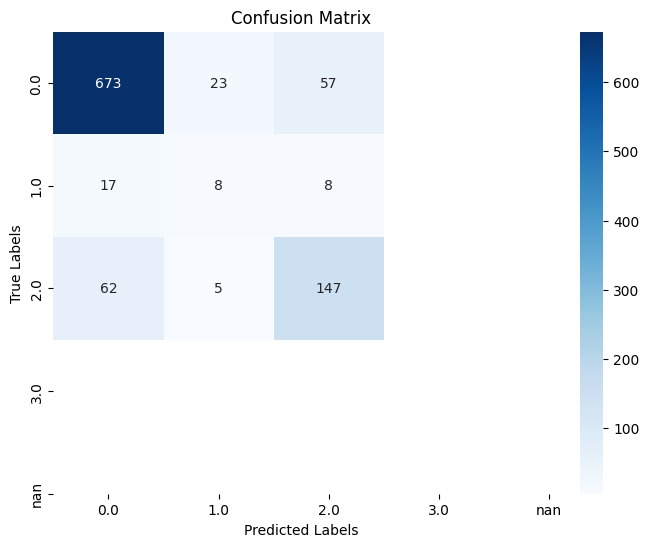

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np

# Load your dataset
data = pd.read_csv('RomanicBanglaSentiment.csv')

# Split data into features (X) and labels (y)
X = data['text']
y = data['sentiment']

# Encode labels into numeric values (convert to str first to avoid float label issues)
label_encoder = LabelEncoder()
y = y.astype(str)  # Ensure labels are string before encoding
y_encoded = label_encoder.fit_transform(y)

# Create a Hugging Face Dataset
data_hf = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data_hf = data_hf.train_test_split(test_size=0.2, seed=42)

# Load a pretrained transformer tokenizer and model
model_name = 'csebuetnlp/banglabert'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data_hf = data_hf.map(tokenize_function, batched=True)
data_hf = data_hf.remove_columns(['text'])
data_hf = data_hf.rename_column('label', 'labels')
data_hf.set_format('torch')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_hf['train'],
    eval_dataset=data_hf['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Generate predictions and evaluate further
predictions_output = trainer.predict(data_hf['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Prepare class names as strings for report and confusion matrix
all_class_indices = list(range(len(label_encoder.classes_)))
class_names = [str(cls) for cls in label_encoder.classes_]

# Classification report
report = classification_report(
    labels,
    predictions,
    labels=all_class_indices,
    target_names=class_names,
    zero_division=0
)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/3999 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1000/1000 [00:00<00:00, 24

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.399300,0.461708,0.824000,0.809905
2,0.369700,0.409689,0.838000,0.824250
3,0.340800,0.500459,0.843000,0.834841
4,0.131100,0.643305,0.840000,0.830921
5,0.138600,0.661679,0.827000,0.828611
6,0.104700,0.710283,0.843000,0.838217
7,0.079000,0.763458,0.834000,0.830667
8,0.037700,0.838883,0.833000,0.828216
9,0.028900,0.871003,0.834000,0.827692
10,0.045300,0.878624,0.833000,0.830374


Evaluation results: {'eval_loss': 0.8786244988441467, 'eval_accuracy': 0.833, 'eval_f1': 0.8303737437539539, 'eval_runtime': 3.4826, 'eval_samples_per_second': 287.141, 'eval_steps_per_second': 18.09, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       753
         1.0       0.31      0.27      0.29        33
         2.0       0.70      0.66      0.68       214

    accuracy                           0.83      1000
   macro avg       0.63      0.61      0.62      1000
weighted avg       0.83      0.83      0.83      1000



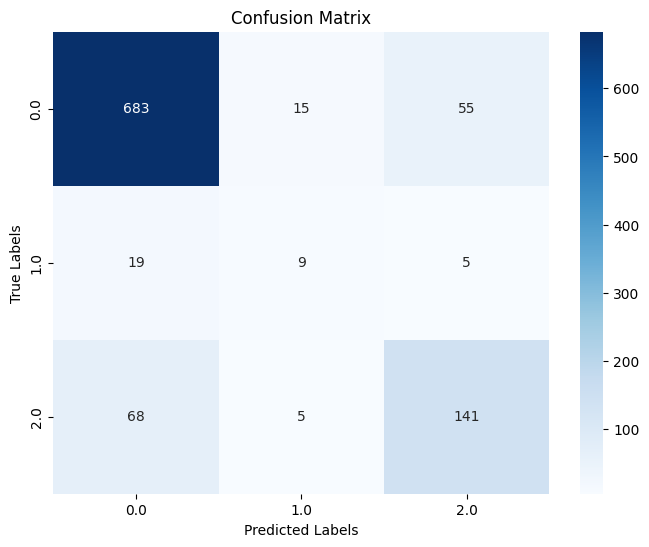

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np

# Load your dataset
data = pd.read_csv('RomanicBanglaSentiment.csv')

# Split data into features (X) and labels (y)
X = data['text']
y = data['sentiment']

# Encode labels into numeric values
label_encoder = LabelEncoder()
y = y.astype(str)  # Ensure labels are strings before encoding
y_encoded = label_encoder.fit_transform(y)

# Create Hugging Face Dataset
data_hf = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data_hf = data_hf.train_test_split(test_size=0.2, seed=42)

# Load pretrained tokenizer and model
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Tokenize dataset
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data_hf = data_hf.map(tokenize_function, batched=True)
data_hf = data_hf.remove_columns(['text'])
data_hf = data_hf.rename_column('label', 'labels')
data_hf.set_format('torch')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_hf['train'],
    eval_dataset=data_hf['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train the model
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Predict
predictions_output = trainer.predict(data_hf['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Get only used labels/classes
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [label_encoder.classes_[i] for i in used_labels]

# Classification report
report = classification_report(
    labels,
    predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [2]:
trainer.save_model('BanglaBERT')